In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import lava.lib.dl.slayer as slayer

import sys
sys.path.insert(0, '/root/lava-dl_experiment/src/')
from dataloader import WISDM_Dataset_parser, WISDM_Dataset
from utils import spike_plot, oversample


In [12]:
device = torch.device('cpu') 

In [13]:
data_len = 10000
dataset = WISDM_Dataset_parser('/root/lava-dl_experiment/data/watch_subset2_40.npz')
train_set = dataset.get_training_set(data_len)

(6,)
(6,)
num classes train dataset: 7 occurrences of each class:[3189 2987 3083 3262 3046 3071 3082]
num classes eval dataset: 7 occurrences of each class:[1050 1017  982  998 1058 1055 1080]
num classes test dataset: 7 occurrences of each class:[1031  948 1014 1076 1062 1038 1072]


In [14]:
time_len = 40
time = np.arange(time_len)
t = torch.FloatTensor(time).to(device)
data, labels  =  train_set

In [15]:
scale = 1<<12 # scale factor for integer simulation
decay_i = torch.FloatTensor([1* scale]).to(device)
decay = torch.FloatTensor([0.1 * scale]).to(device)
initial_state = torch.FloatTensor([0]).to(device)
threshold = 1.5
second_order_th = threshold * 3

Text(0.5, 0, 'time')

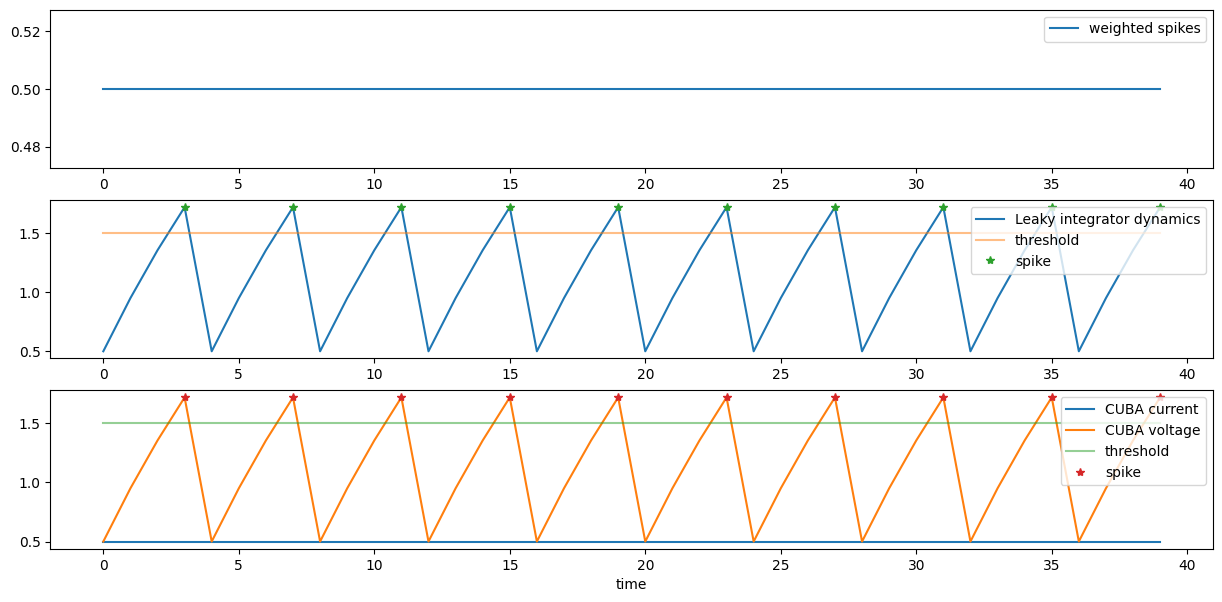

In [16]:
input = torch.FloatTensor(np.ones((40,))*0.5).to(device)
y = slayer.neuron.dynamics.leaky_integrator.dynamics(input, decay=decay, state=initial_state, w_scale=scale, threshold=threshold)
current = slayer.neuron.dynamics.leaky_integrator.dynamics(input, decay=decay_i, state=initial_state, w_scale=scale)
voltage = slayer.neuron.dynamics.leaky_integrator.dynamics(current, decay=decay, state=initial_state, w_scale=scale, threshold=threshold)

sp = slayer.spike.Spike.apply(
        y, 
        threshold, 
        1, # tau_rho: gradient relaxation constant 
        1, # scale_rho: gradient scale constant
        False, # graded_spike: graded or binary spike 
        0, # voltage_last: voltage at t=-1
        1, # scale: graded spike scale 
    )

sp2 = slayer.spike.Spike.apply(
        voltage, 
        threshold, 
        1, # tau_rho: gradient relaxation constant 
        1, # scale_rho: gradient scale constant
        False, # graded_spike: graded or binary spike 
        0, # voltage_last: voltage at t=-1
        1, # scale: graded spike scale 
    )

fig,ax = plt.subplots(3, 1, figsize=(15, 7))
ax[0].plot(time, input.cpu(), label='weighted spikes')
ax[0].legend(loc='upper right')

ax[1].plot(time, y.cpu(), label='Leaky integrator dynamics')
ax[1].plot(time, threshold * np.ones_like(time), alpha=0.5, label='threshold')
ax[1].plot(time[sp>0], y[sp>0], '*', label='spike')
ax[1].legend(loc='upper right')
ax[2].plot(time, current.cpu(), label='CUBA current')
ax[2].plot(time, voltage.cpu(), label='CUBA voltage')
ax[2].plot(time, threshold * np.ones_like(time), alpha=0.5, label='threshold')
ax[2].plot(time[sp2>0], voltage[sp2>0].cpu(),'*', label='spike')
ax[2].legend(loc='upper right')

ax[-1].set_xlabel('time')

Text(0.5, 0, 'time')

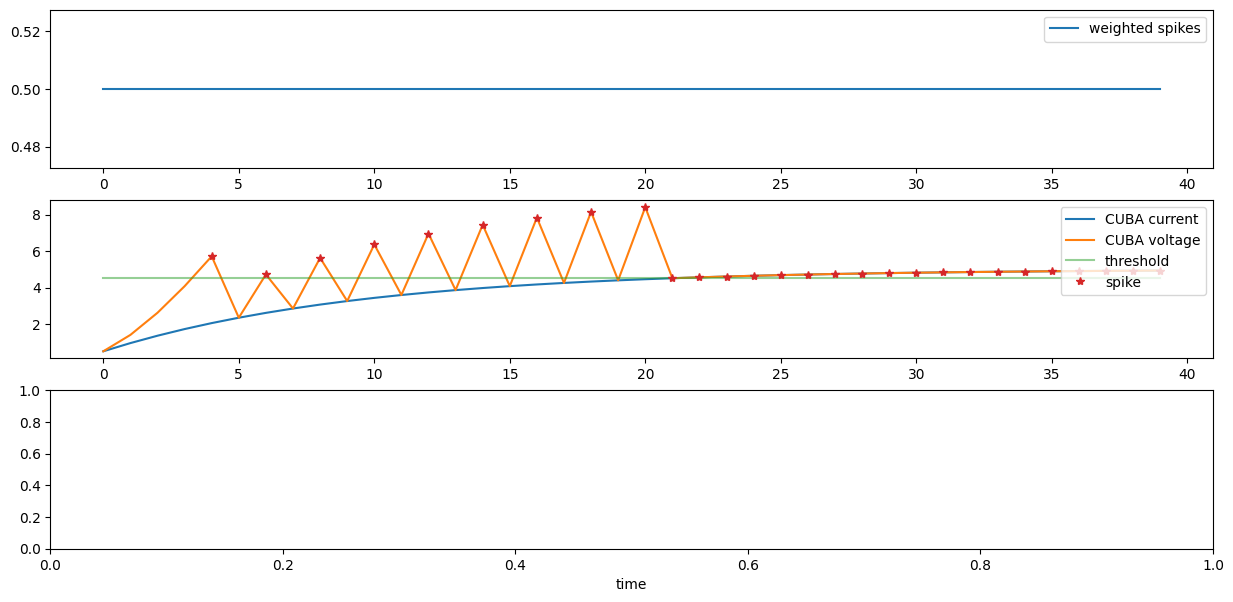

In [17]:

current = slayer.neuron.dynamics.leaky_integrator.dynamics(input, decay=decay, state=initial_state, w_scale=scale)
voltage = slayer.neuron.dynamics.leaky_integrator.dynamics(current, decay=decay, state=initial_state, w_scale=scale, threshold=second_order_th)

sp2 = slayer.spike.Spike.apply(
        voltage, 
        second_order_th, 
        1, # tau_rho: gradient relaxation constant 
        1, # scale_rho: gradient scale constant
        False, # graded_spike: graded or binary spike 
        0, # voltage_last: voltage at t=-1
        1, # scale: graded spike scale 
    )

fig,ax = plt.subplots(3, 1, figsize=(15, 7))
ax[0].plot(time, input.cpu(), label='weighted spikes')
ax[0].legend(loc='upper right')

ax[1].plot(time, current.cpu(), label='CUBA current')
ax[1].plot(time, voltage.cpu(), label='CUBA voltage')
ax[1].plot(time, second_order_th * np.ones_like(time), alpha=0.5, label='threshold')
ax[1].plot(time[sp2>0], voltage[sp2>0].cpu(),'*', label='spike')
ax[1].legend(loc='upper right')

ax[-1].set_xlabel('time')

# Output information to take in account

lower bound fo the voltage is the input current for the LIF, previous current for CUBA. 
Costant signal saturate the CUBA neuron. while it generate different spikerate for each valure, higher the value higher is the hz of the spike

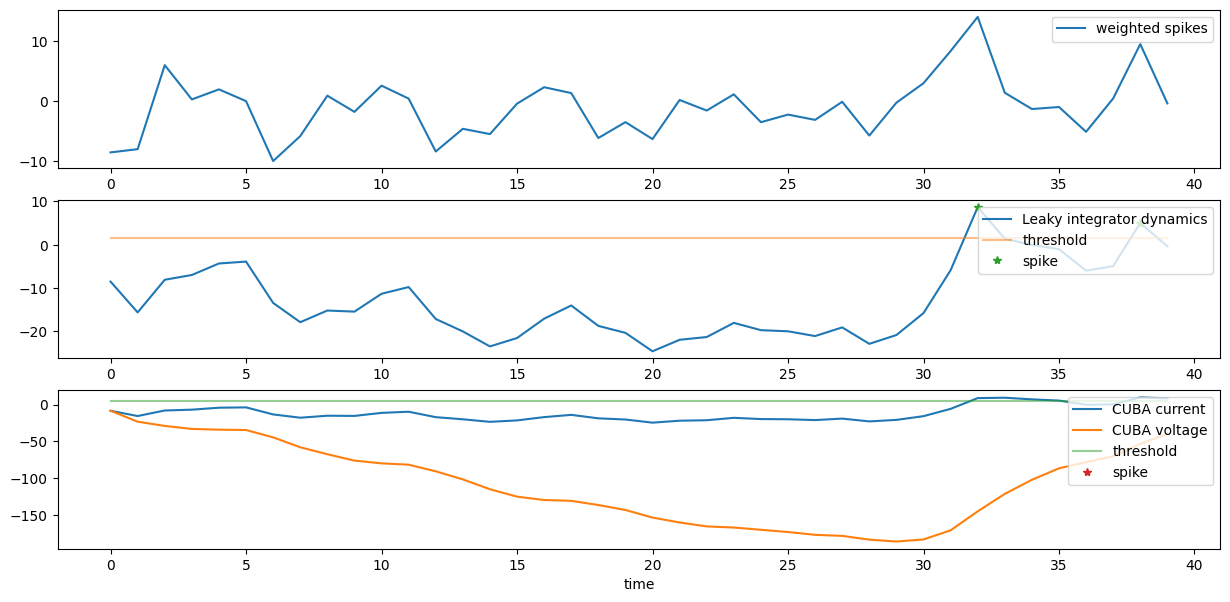

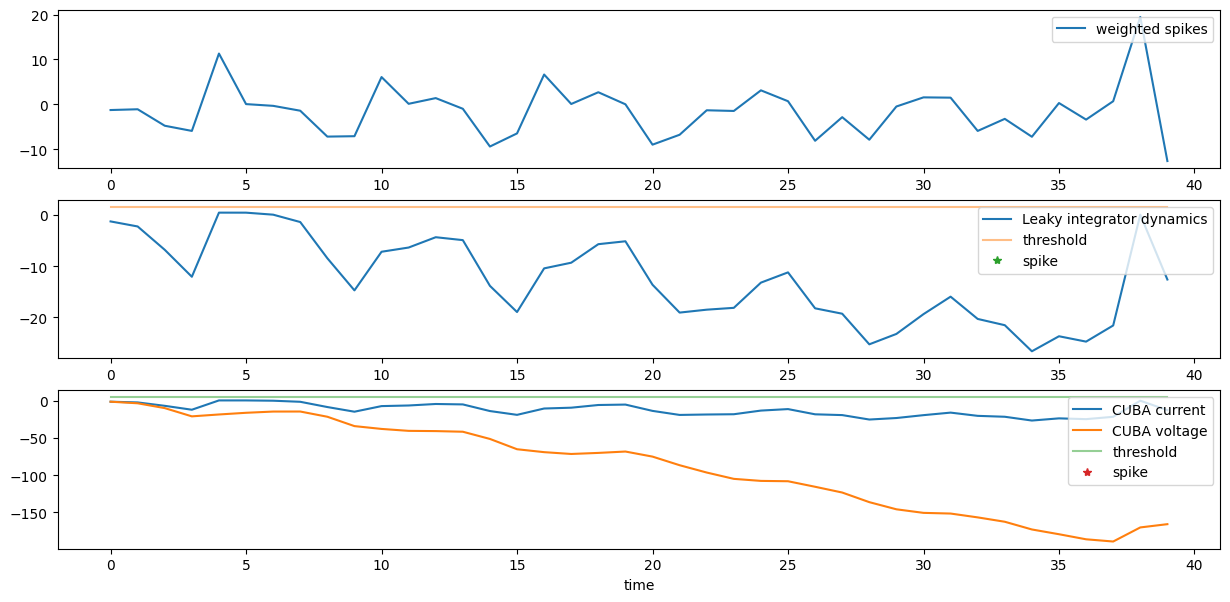

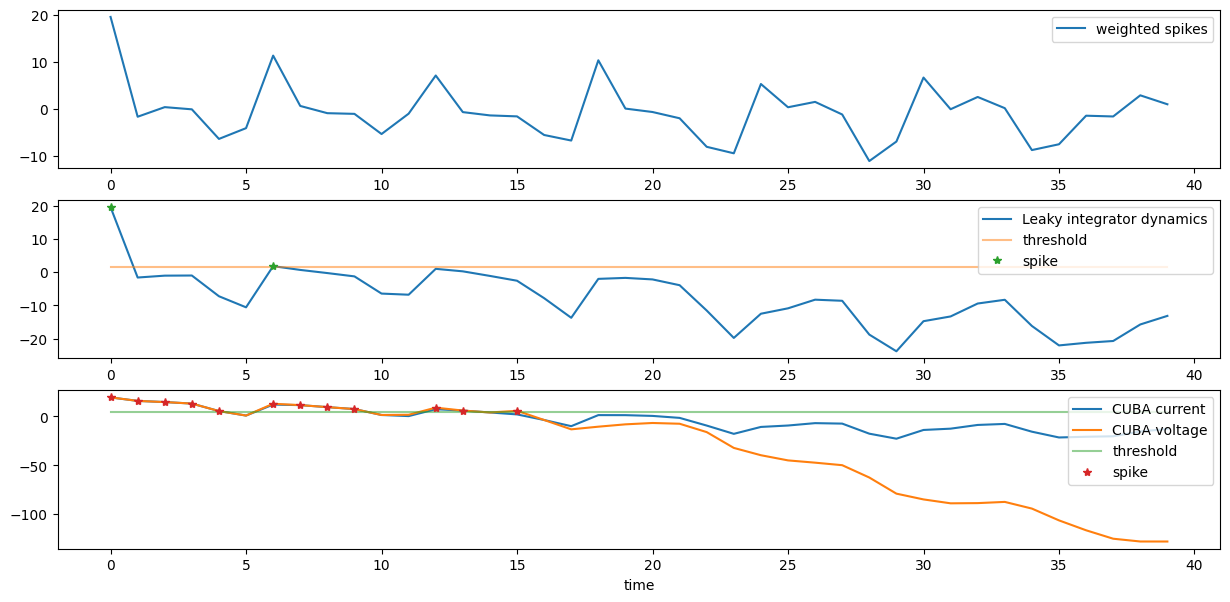

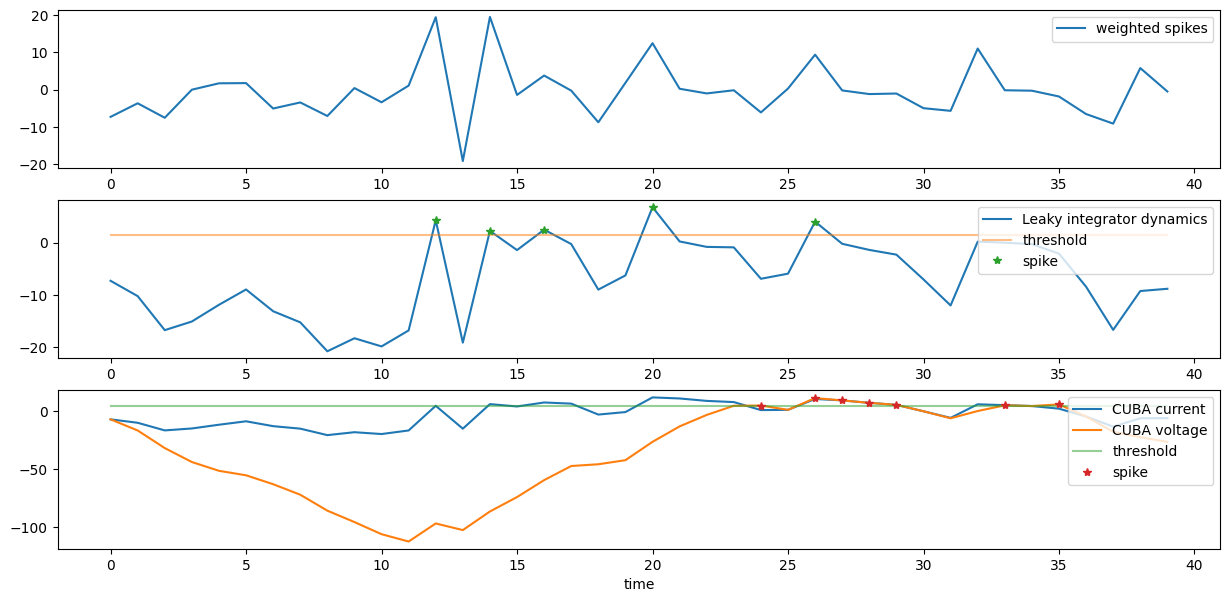

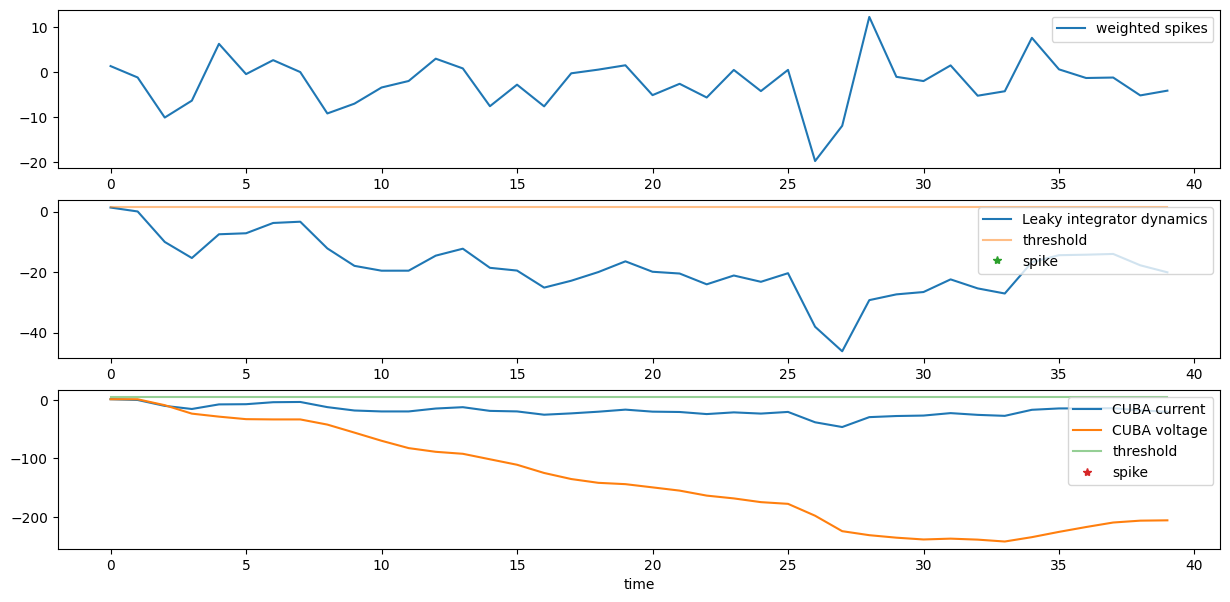

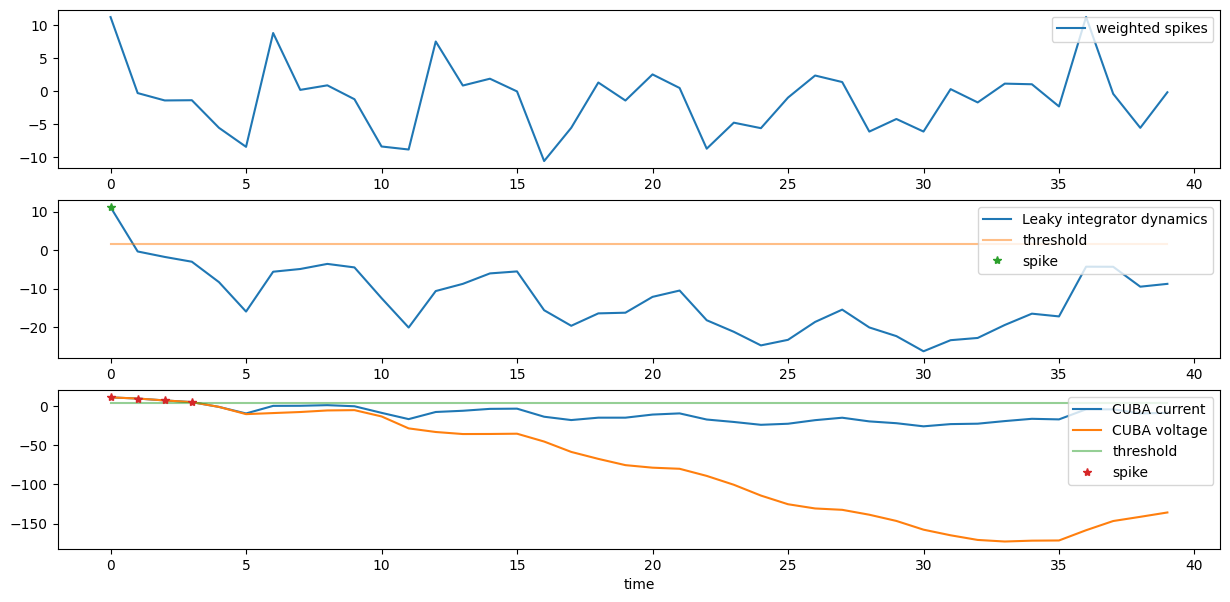

In [18]:
index =np.random.randint(0,data_len)
x, label = torch.FloatTensor(data[index]).to(device), labels[index]

for input in x:
    y = slayer.neuron.dynamics.leaky_integrator.dynamics(input, decay=decay, state=initial_state, w_scale=scale, threshold=threshold)
    current = slayer.neuron.dynamics.leaky_integrator.dynamics(input, decay=decay, state=initial_state, w_scale=scale)
    voltage = slayer.neuron.dynamics.leaky_integrator.dynamics(current, decay=decay, state=initial_state, w_scale=scale, threshold=second_order_th)

    sp = slayer.spike.Spike.apply(
            y, 
            threshold, 
            1, # tau_rho: gradient relaxation constant 
            1, # scale_rho: gradient scale constant
            False, # graded_spike: graded or binary spike 
            0, # voltage_last: voltage at t=-1
            1, # scale: graded spike scale 
        )

    sp2 = slayer.spike.Spike.apply(
            voltage, 
            second_order_th,  
            1, # tau_rho: gradient relaxation constant 
            1, # scale_rho: gradient scale constant
            False, # graded_spike: graded or binary spike 
            0, # voltage_last: voltage at t=-1
            1, # scale: graded spike scale 
        )

    fig,ax = plt.subplots(3, 1, figsize=(15, 7))
    ax[0].plot(time, input.cpu(), label='weighted spikes')
    ax[0].legend(loc='upper right')

    ax[1].plot(time, y.cpu(), label='Leaky integrator dynamics')
    ax[1].plot(time, threshold * np.ones_like(time), alpha=0.5, label='threshold')
    ax[1].plot(time[sp>0], y[sp>0], '*', label='spike')
    ax[1].legend(loc='upper right')

    ax[2].plot(time, current.cpu(), label='CUBA current')
    ax[2].plot(time, voltage.cpu(), label='CUBA voltage')
    ax[2].plot(time, second_order_th * np.ones_like(time), alpha=0.5, label='threshold')
    ax[2].plot(time[sp2>0], voltage[sp2>0].cpu(),'*', label='spike')
    ax[2].legend(loc='upper right')

    ax[-1].set_xlabel('time')

# Found problem in the signal preprocessing
normalizing around zeros for signals in this field is not benefitial. Negative value penalize a lot the current/voltage, leading to negative voltages that catrries to basically dead neurons. 

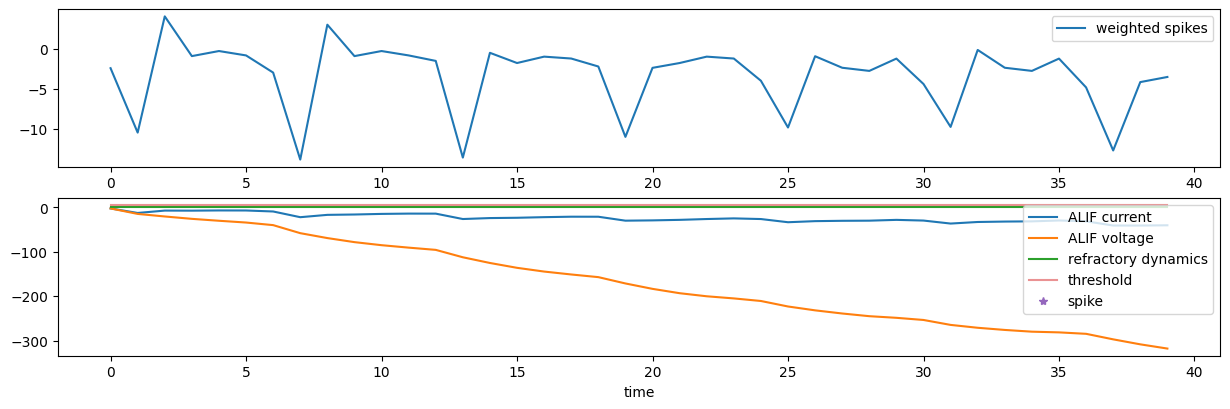

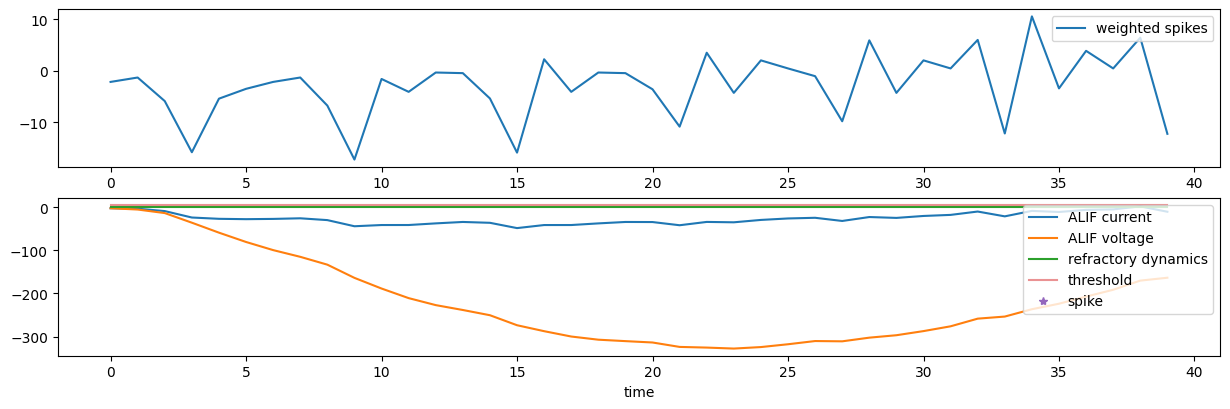

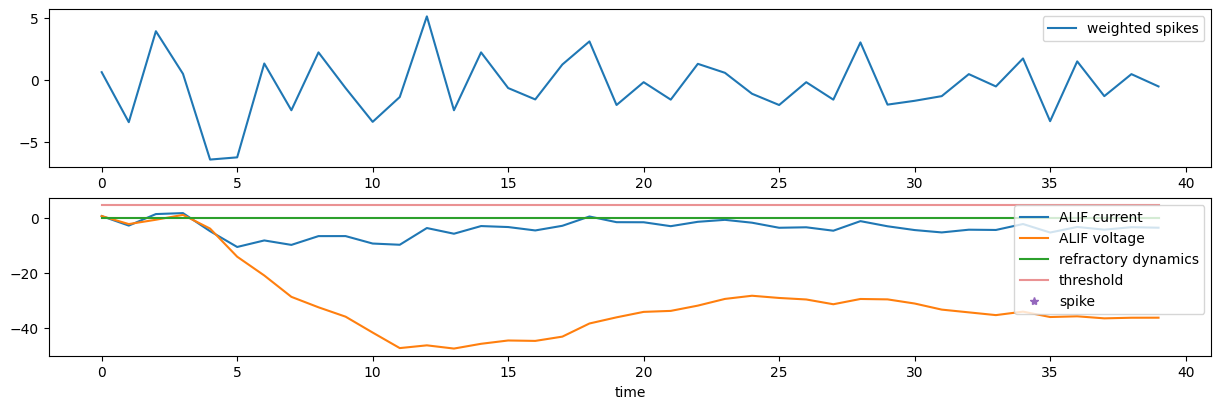

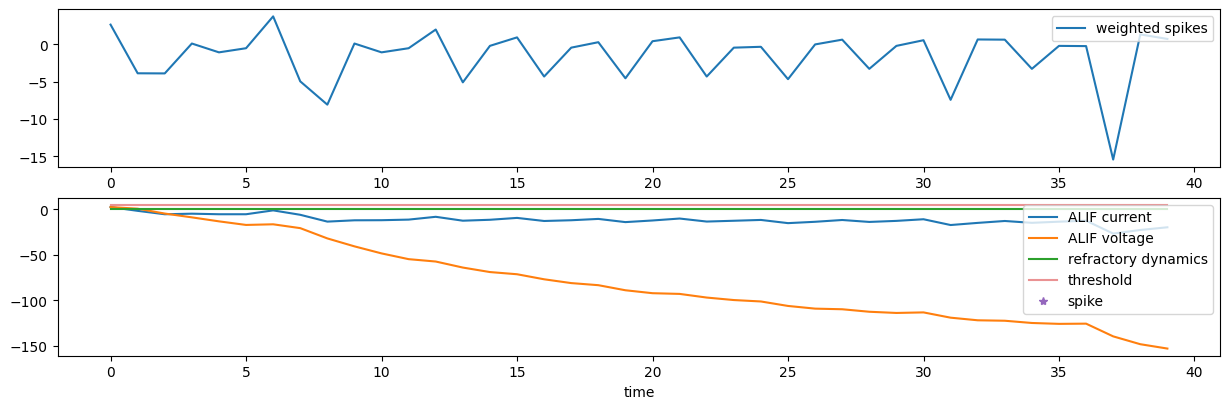

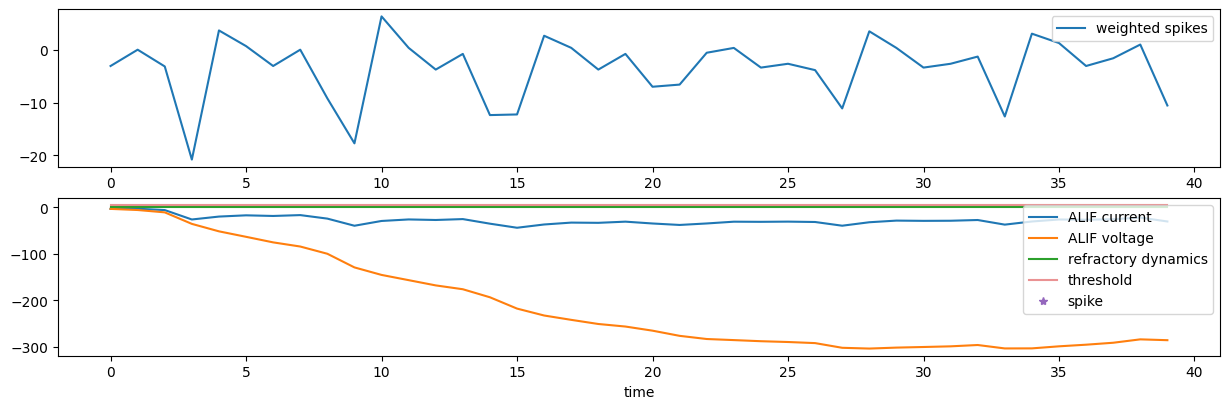

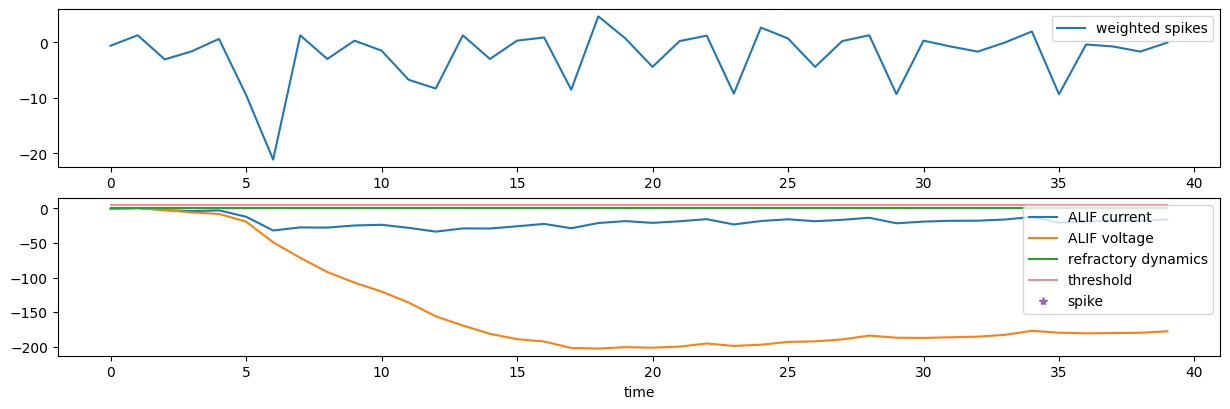

In [19]:
index =np.random.randint(0,data_len)
x, label = torch.FloatTensor(data[index]).to(device), labels[index]

for input in x:
    current = slayer.neuron.dynamics.leaky_integrator.dynamics(input, decay=decay, state=initial_state, w_scale=scale)
    voltage = slayer.neuron.dynamics.leaky_integrator.dynamics(current, decay=decay, state=initial_state, w_scale=scale)
    th, ref = slayer.neuron.dynamics.adaptive_threshold.dynamics(
            voltage,                      # dynamics state
            ref_state=initial_state,      # previous refractory state
            ref_decay=0.5*decay,          # refractory decay
            th_state=initial_state + second_order_th, # previous threshold state
            th_decay=decay,               # threshold decay
            th_scale=0.5*second_order_th, # threshold step
            th0=second_order_th,          # threshold stable state
            w_scale=scale                 # fixed precision scaling
        )
    fig,ax = plt.subplots(2, 1, figsize=(15, 4.5))
    ax[0].plot(time, input.cpu(), label='weighted spikes')
    ax[0].legend(loc='upper right')

    ax[1].plot(time, current.cpu(), label='ALIF current')
    ax[1].plot(time, voltage.cpu(), label='ALIF voltage')
    ax[1].plot(time, ref.cpu(), label='refractory dynamics')
    ax[1].plot(time, th.cpu(), alpha=0.5, label='threshold')
    ax[1].plot(time[(voltage-ref)>th], voltage[(voltage-ref)>th], '*', label='spike')
    ax[1].legend(loc='upper right')

    ax[-1].set_xlabel('time')

Text(0.5, 0, 'time')

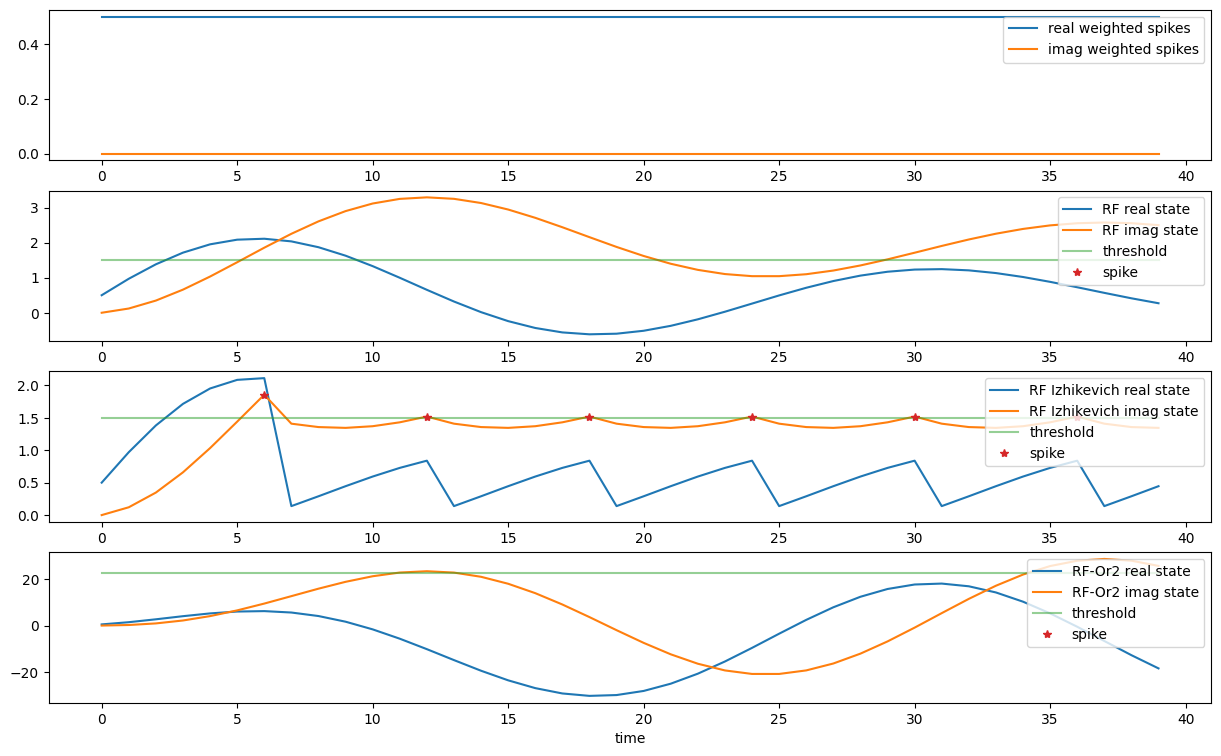

In [22]:
#for input in x:
input = torch.FloatTensor(np.ones((40,))*0.5).to(device)
re_input = input
#im_input = 2*torch.randn_like(re_input) * (re_input > 0)
im_input = torch.FloatTensor(np.ones((40,))*0).to(device)
alpha = torch.FloatTensor([0.03 * scale]).to(device)
phi = 2 * np.pi /25
sin_decay = (scale-alpha) * np.sin(phi)
cos_decay = (scale-alpha) * np.cos(phi)
re, im = slayer.neuron.dynamics.resonator.dynamics(
        re_input, im_input, 
        sin_decay, cos_decay, 
        real_state=initial_state, 
        imag_state=initial_state, 
        w_scale=scale,
    )
sp = slayer.spike.complex.Spike.apply(
    re, im, 
    threshold,
    1, # tau_rho: gradient relaxation constant 
    1, # scale_rho: gradient scale constant
    False, # graded_spike: graded or binary spike 
    0, # voltage_last: voltage at t=-1
    1, # scale: graded spike scale 
)
iz_re, iz_im = slayer.neuron.dynamics.resonator.dynamics(
    re_input, im_input, 
    sin_decay, cos_decay, 
    real_state=initial_state, 
    imag_state=initial_state, 
    w_scale=scale,
    threshold=threshold,
)
second_order_th = threshold * 15
re_0, im_0 = slayer.neuron.dynamics.resonator.dynamics(
        re_input, im_input, 
        sin_decay, cos_decay, 
        real_state=initial_state, 
        imag_state=initial_state, 
        w_scale=scale,
    )
re_1, im_1 = slayer.neuron.dynamics.resonator.dynamics(
        re_0, im_0, 
        sin_decay, cos_decay, 
        real_state=initial_state, 
        imag_state=initial_state, 
        w_scale=scale,
    )

sp_1 = slayer.spike.complex.Spike.apply(re_1, im_1, second_order_th, 1, 1, False, 0, 1)
fig,ax = plt.subplots(4, 1, figsize=(15, 9))
ax[0].plot(time, re_input.cpu(), label='real weighted spikes')
ax[0].plot(time, im_input.cpu(), label='imag weighted spikes')
ax[0].legend(loc='upper right')

ax[1].plot(time, re.cpu(), label='RF real state')
ax[1].plot(time, im.cpu(), label='RF imag state')
ax[1].plot(time, threshold * np.ones_like(time), alpha=0.5, label='threshold')
ax[1].plot(time[sp>0], re[sp>0], '*', label='spike')
ax[1].legend(loc='upper right')
ax[2].plot(time, iz_re.cpu(), label='RF Izhikevich real state')
ax[2].plot(time, iz_im.cpu(), label='RF Izhikevich imag state')
ax[2].plot(time, threshold * np.ones_like(time), alpha=0.5, label='threshold')
ax[2].plot(time[iz_im > threshold], iz_im[iz_im > threshold], '*', label='spike')
ax[2].legend(loc='upper right')

ax[3].plot(time, re_1.cpu(), label='RF-Or2 real state')
ax[3].plot(time, im_1.cpu(), label='RF-Or2 imag state')
ax[3].plot(time, second_order_th * np.ones_like(time), alpha=0.5, label='threshold')
ax[3].plot(time[sp_1>0], re_1[sp_1>0], '*', label='spike')
ax[3].legend(loc='upper right')

ax[-1].set_xlabel('time')
